In [454]:
from kan import *
import torch
from torch import autograd
from tqdm import tqdm
from pyscf import gto, scf
from collections import Counter


#%pip install ipympl
%pip install --upgrade jupyter matplotlib ipympl
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipympl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.




[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [455]:
#  # testing if 
# x = torch.zeros(train_num, 2)
# x[:, 0] = 20 * torch.rand(train_num)  # Random numbers from 0 to 20
# x[:, 1] = torch.pi * torch.rand(train_num) # Random numbers from 0 to π
# x

# # create dataset


# def create_dataset(train_num=10000, test_num=10000):

#     def generate_contrastive(x):
#         # positive samples
#         batch = x.shape[0]
#         x[:,0] = (1 / torch.sqrt(32 * torch.pi)) * x[:,[0]] * torch.exp((-1/2) * x[:,[0]])
#         x[:,1] = torch.cos(x[:,[1]] * torch.pi/20)

#         # negative samples
#         def corrupt(tensor):
#             y = copy.deepcopy(tensor)
#             for i in range(y.shape[1]):
#                 y[:,i] = y[:,i][torch.randperm(y.shape[0])]
#             return y

#         x_cor = corrupt(x)
#         x = torch.cat([x, x_cor], dim=0)
#         y = torch.cat([torch.ones(batch,), torch.zeros(batch,)], dim=0)[:,None]
#         return x, y

#     x = torch.rand(train_num, 6) * 2 - 1
#     x_train, y_train = generate_contrastive(x)

#     x = torch.rand(test_num, 6) * 2 - 1
#     x_test, y_test = generate_contrastive(x)

#     dataset = {}
#     dataset['train_input'] = x_train.to(device)
#     dataset['test_input'] = x_test.to(device)
#     dataset['train_label'] = y_train.to(device)
#     dataset['test_label'] = y_test.to(device)
#     return dataset

# dataset = create_dataset()

In [505]:
# Total number of electrons
total_electrons = 1
total_electrons

NUM_ELECTRONS = total_electrons
INPUT_DIM = NUM_ELECTRONS
OUTPUT_DIM = NUM_ELECTRONS

# Create dataset
f = lambda x: (1 / torch.sqrt(torch.tensor(32.0 * torch.pi))) * x[:,[0]] * torch.exp((-1/2) * x[:,[0]]) * torch.sin(x[:,[1]] * torch.pi/20) * torch.sin(x[:,[2]] * torch.pi/10) * torch.sin(x[:,[3]] * torch.pi/10) * torch.sin(x[:,[4]] * torch.pi/10)
dataset = create_dataset(f, n_var=6, ranges=[0,20], train_num=5000, test_num=5000)
print("Dataset shapes:", dataset['train_input'].shape, dataset['train_label'].shape)

Dataset shapes: torch.Size([5000, 6]) torch.Size([5000, 1])


In [501]:
# plt.figure(figsize=(10, 6))
# x = dataset['train_input'][:,0]
# x_1 = dataset['train_input'][:,1]
# #x_2 = dataset['train_input'][:,2]
# y = dataset['train_label'][:].detach().cpu().numpy().flatten()
# plt.scatter(x, y, alpha=0.5, s=2)
# plt.scatter(x_1, y, alpha=0.5, s=2, c='green')
# #plt.scatter(x_2, y, alpha=0.5, s=2, c='red')
# plt.xlabel('x')
# plt.ylabel('Value')
# # plt.show()
# print(dataset['train_input'][:,0].max() - dataset['train_input'][:,0].numpy().min())

In [502]:
# import plotly.express as px
# import pandas as pd
# import numpy as np

# # Extract radial and angular components
# func = dataset['train_label'][:].detach().cpu().numpy().flatten()  # full function
# r = func
# theta = dataset['train_input'][:,1].detach().cpu().numpy().flatten() * np.pi / 20 # angular for theta, i.e. polar angle down from z-axis
# phi = dataset['train_input'][:,2].detach().cpu().numpy().flatten() * np.pi / 10
# #phi = 2 * torch.pi * torch.rand(r.shape[0]).numpy().flatten()
# # theta = torch.pi * torch.rand(r.shape[0]).numpy().flatten()

# print(r.max(), r.min(), 'theta', theta.min(), theta.max(), 'phi', phi.min(), phi.max())
# # Convert to Cartesian coordinates - remove last angular component for whichever axis should have node until l = 2
# x = r * np.sin(theta) * np.cos(phi)
# y = r * np.sin(theta) #* np.sin(phi)
# z = r * np.cos(theta)


# # Create DataFrame
# df = pd.DataFrame({
#     'X': x,
#     'Y': y,
#     'Z': z
# })

# fig = px.scatter_3d(df, 
#                     x='X', 
#                     y='Y', 
#                     z='Z',
#                     color='Z',
#                     color_continuous_scale='viridis',
#                     opacity=0.6,
#                     title='3D Plot in Cartesian Coordinates')

# fig.update_traces(marker=dict(size=2))  # Uniform size for all markers
# fig.show()

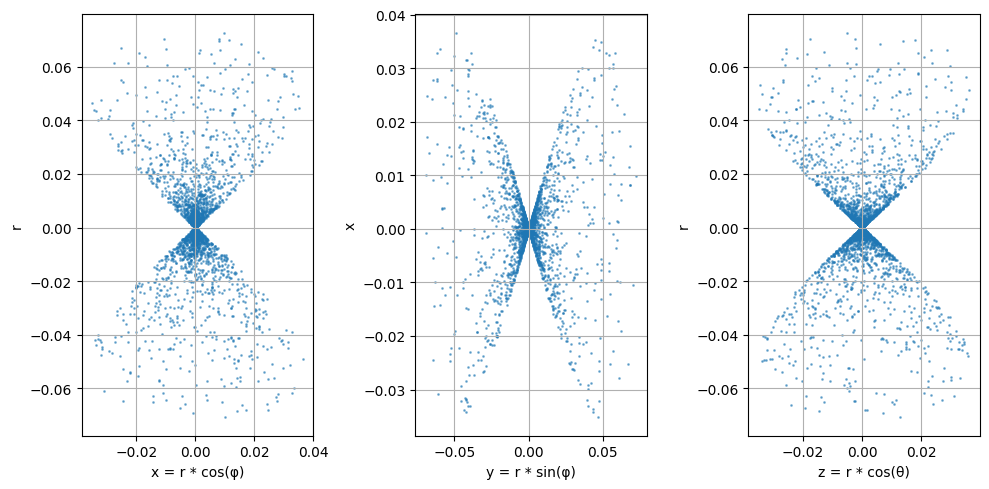

In [459]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

# Plot x = r * cos(phi)
ax1.scatter(x, r, alpha=0.5, s=1)
ax1.set_ylabel('r')
ax1.set_xlabel('x = r * cos(φ)')
ax1.grid(True)

# Plot y = r * sin(phi)
ax2.scatter(y, x, alpha=0.5, s=1)
ax2.set_ylabel('x')
ax2.set_xlabel('y = r * sin(φ)')
ax2.grid(True)

# Plot z = r * cos(π/2 - θ)
ax3.scatter(z, r, alpha=0.5, s=1)
ax3.set_ylabel('r')
ax3.set_xlabel('z = r * cos(θ)')
ax3.grid(True)

plt.tight_layout()
plt.show()

In [510]:
# Create MultKAN model with specified widths
# Create the initial MultKAN model
model = MultKAN(width=[6,[0,2], 1], grid=5, k=4, seed=42, mult_arity=3, base_fun='identity')
#model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

checkpoint directory created: ./model
saving model version 0.0


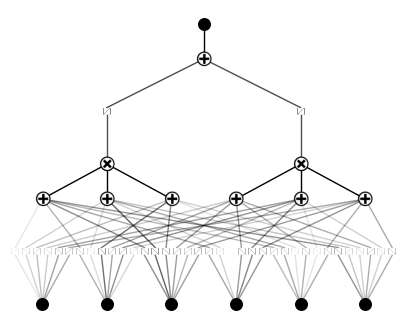

In [518]:
model(dataset['train_input'])
model.plot(beta=1)

In [512]:
# model.module(0, '[0]->[0]')
# model.module(0, '[1]->[1]')
# model.module(0, '[2]->[2]')
# model.plot(beta=1)

In [493]:
model.fit(dataset, steps=100)

| train_loss: 7.41e-03 | test_loss: 7.47e-03 | reg: 6.93e+00 | : 100%|█| 100/100 [00:17<00:00,  5.62


saving model version 0.1


{'train_loss': [array(0.00809091, dtype=float32),
  array(0.00781059, dtype=float32),
  array(0.00780663, dtype=float32),
  array(0.00778057, dtype=float32),
  array(0.00777078, dtype=float32),
  array(0.00774626, dtype=float32),
  array(0.0077422, dtype=float32),
  array(0.0077422, dtype=float32),
  array(0.00774191, dtype=float32),
  array(0.00774191, dtype=float32),
  array(0.00774181, dtype=float32),
  array(0.00774181, dtype=float32),
  array(0.00774181, dtype=float32),
  array(0.00774181, dtype=float32),
  array(0.00774181, dtype=float32),
  array(0.00774186, dtype=float32),
  array(0.00774186, dtype=float32),
  array(0.00774186, dtype=float32),
  array(0.00774158, dtype=float32),
  array(0.00774158, dtype=float32),
  array(0.00774156, dtype=float32),
  array(0.00774039, dtype=float32),
  array(0.00773855, dtype=float32),
  array(0.00773786, dtype=float32),
  array(0.00773757, dtype=float32),
  array(0.00773384, dtype=float32),
  array(0.00773041, dtype=float32),
  array(0.007667

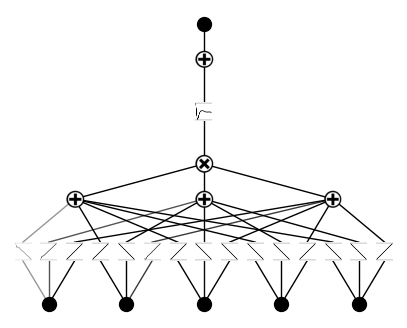

In [496]:
model.plot(beta=20)

In [497]:
grids = np.array([3,10,20])

train_losses = []
test_losses = []
steps = 25

for i in range(grids.shape[0]):
        model = model.refine(grids[i])
        results = model.fit(dataset, opt="LBFGS", steps=steps)
        train_losses += results['train_loss']
        test_losses += results['test_loss']

saving model version 0.2


| train_loss: 7.39e-03 | test_loss: 7.45e-03 | reg: 7.20e+00 | : 100%|█| 25/25 [00:02<00:00, 10.14it


saving model version 0.3
saving model version 0.4


| train_loss: 7.37e-03 | test_loss: 7.43e-03 | reg: 7.22e+00 | : 100%|█| 25/25 [00:03<00:00,  6.25it


saving model version 0.5
saving model version 0.6


| train_loss: 7.34e-03 | test_loss: 7.45e-03 | reg: 7.24e+00 | : 100%|█| 25/25 [00:06<00:00,  3.60it

saving model version 0.7


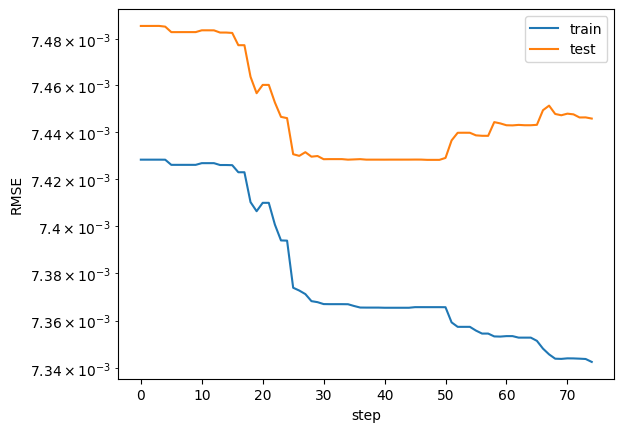

In [498]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

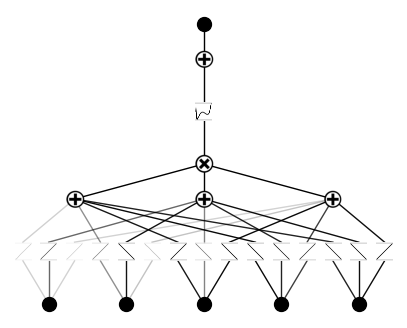

In [499]:
model.plot()

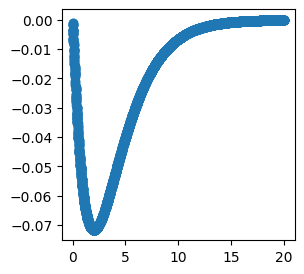

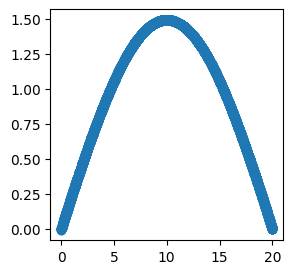

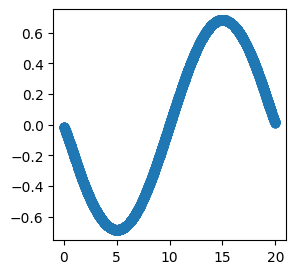

In [468]:
function_1 = np.array(model.get_fun(0,0,0))
function_2 = np.array(model.get_fun(0,1,1))
function_3 = np.array(model.get_fun(0,2,2))

In [469]:
total_fun2 = function_1[1] * function_2[1] * function_3[1]
total_fun1 = function_1[0]

In [470]:
model.unfix_symbolic_all()

saving model version 0.11
saving model version 0.12
saving model version 0.13
saving model version 0.14
saving model version 0.15
saving model version 0.16
saving model version 0.17
saving model version 0.18
saving model version 0.19


In [471]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,1,'x')
    model.fix_symbolic(0,0,1,'exp')
elif mode == "auto":
    # automatic mode
    lib = ['x','exp', 'x^2', 'sin', 'cos']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.7118766903877258, c=1
fixing (0,0,1) with x, r2=0.0, c=1
fixing (0,0,2) with x, r2=0.0, c=1
fixing (0,1,0) with x, r2=0.0, c=1
fixing (0,1,1) with sin, r2=0.9996331930160522, c=2
fixing (0,1,2) with x, r2=0.0, c=1
fixing (0,2,0) with x, r2=0.0, c=1
fixing (0,2,1) with x, r2=0.0, c=1
fixing (0,2,2) with x, r2=0.6144907474517822, c=1
saving model version 0.20


In [472]:
sf = model.symbolic_formula()[0][0]

In [473]:
nsimplify(ex_round(ex_round(sf, 3),3))

(100/339 - 1209*sin(9*x_2/50 + 46/5)/1000)*(x_1/334 - 2/37)*(x_3/15 - 81/122)

-0.0016615445 0.030482313


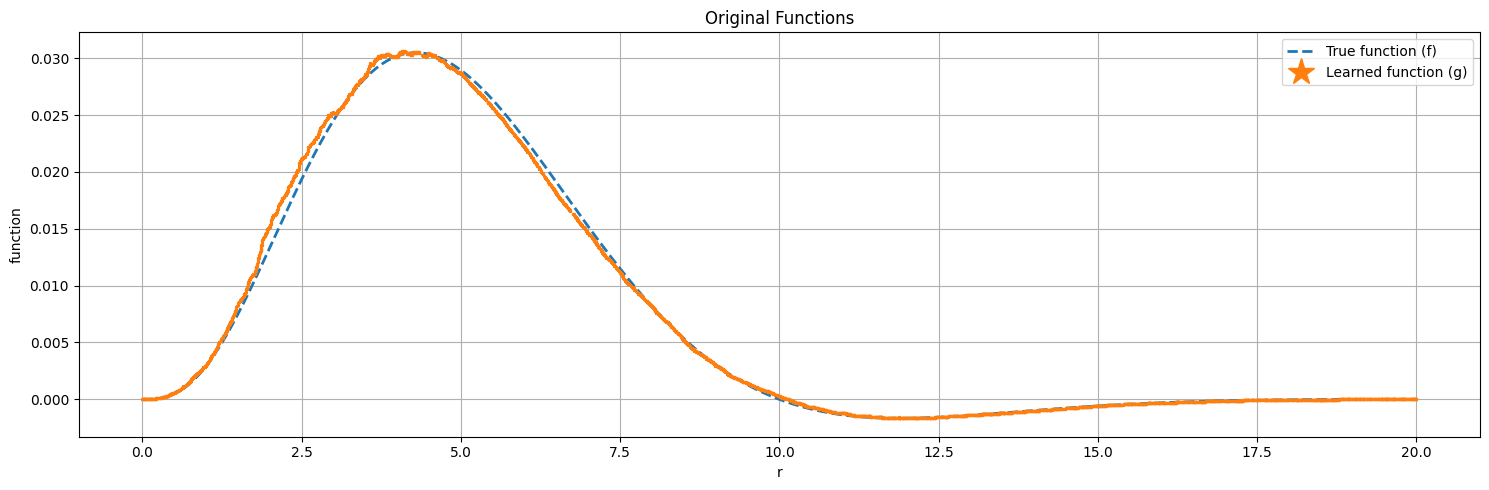

In [474]:
x = total_fun1.reshape(-1, 1)

f = (1 / np.sqrt(32.0 * np.pi)) * x * np.exp((-1/2) * x) * np.sin(x * np.pi/20) * np.sin(x * np.pi/10)
g = total_fun2.reshape(-1, 1)
#h = total_fun1.reshape(-1, 1) * np.pi / 20
h = dataset['train_input'][:,2].detach().cpu().numpy().flatten() * np.pi / 400
p = dataset['train_label'][:].detach().cpu().numpy().flatten()

print(f.min(), f.max())

# Create subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5))

# Regular functions plot
ax1.plot(x, f, '--', label='True function (f)', linewidth=2)
ax1.plot(x, g, '*', label='Learned function (g)', linewidth=1, markersize=2)
#ax1.plot(x, h, '*', label='Learned function (g)', linewidth=1, markersize=2)
ax1.set_xlabel('r')
ax1.set_ylabel('function')
ax1.set_title('Original Functions')
ax1.legend(markerscale=10)
ax1.grid(True)


plt.tight_layout()
plt.show()

In [475]:
mse = np.mean((f - g) ** 2)
print(f"Mean Squared Error: {mse:.10f}")

Mean Squared Error: 0.0000002471


In [476]:
import plotly.express as px
import pandas as pd
import numpy as np

# Extract radial and angular components
f_rt = total_fun2 # gives function curve
phi = np.random.rand(f_rt.shape[0]) * torch.pi * 2
theta = np.random.rand(f_rt.shape[0]) * torch.pi
r = f_rt # radial values given by function curve mulitplied by cos(theta) where theta between 0 and pi
#r_1 = f_rt * np.sin(theta) # radial values given by function curve mulitplied by cos(theta) where theta between 0 and pi

# Convert to Cartesian coordinates
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

# # Scale to -5 to 5 range
# def scale_to_range(arr, min_val=-5, max_val=5):
#     return (max_val - min_val) * (arr - arr.min()) / (arr.max() - arr.min()) + min_val

# x = scale_to_range(x)
# y = scale_to_range(y)
# z = scale_to_range(z)

# Create DataFrame
df = pd.DataFrame({
    'X': x,
    'Y': y,
    'Z': z
})

fig = px.scatter_3d(df, 
                    x='X', 
                    y='Y', 
                    z='Z',
                    color='Z',
                    color_continuous_scale='viridis',
                    opacity=0.6,
                    title='3D Plot in Cartesian Coordinates')

# Set axis ranges
# fig.update_layout(scene=dict(
#     xaxis=dict(range=[-0.08, 0.08]),
#     yaxis=dict(range=[-0.08, 0.08]),
#     zaxis=dict(range=[-0.08, 0.08])
# ))

fig.update_traces(marker=dict(size=2))  # Uniform size for all markers
fig.show()

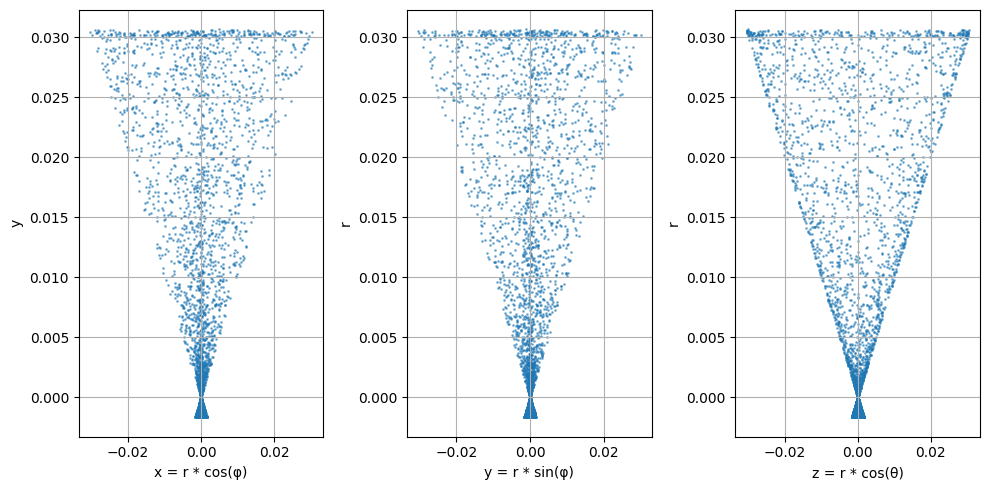

In [477]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

# Plot x = r * cos(phi)
ax1.scatter(x, r, alpha=0.5, s=1)
ax1.set_ylabel('y')
ax1.set_xlabel('x = r * cos(φ)')
ax1.grid(True)

# Plot y = r * sin(phi)
ax2.scatter(y, r, alpha=0.5, s=1)
ax2.set_ylabel('r')
ax2.set_xlabel('y = r * sin(φ)')
ax2.grid(True)

# Plot z = r * cos(π/2 - θ)
ax3.scatter(z, r, alpha=0.5, s=1)
ax3.set_ylabel('r')
ax3.set_xlabel('z = r * cos(θ)')
ax3.grid(True)

plt.tight_layout()
plt.show()

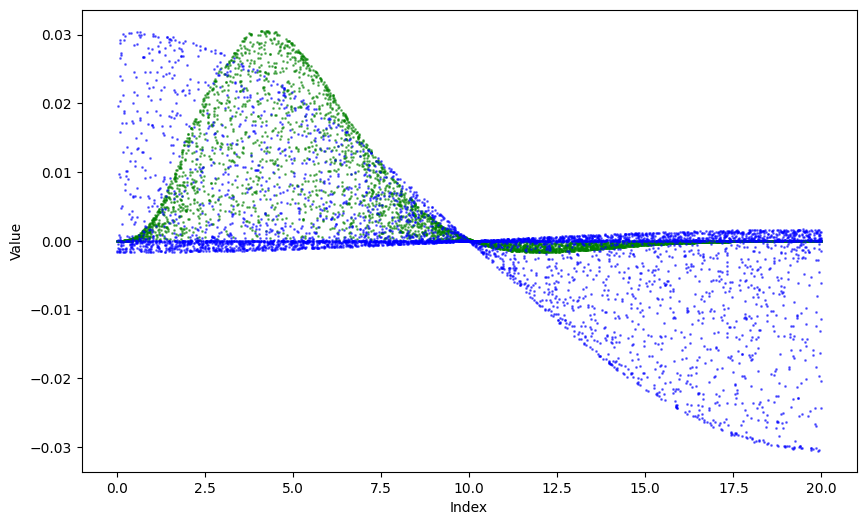

5000


In [478]:

plt.figure(figsize=(10, 6))
index = total_fun1.reshape(-1, 1)# == index = np.arange(len(z)) for plotting
x_1 = dataset['train_input'][:,0]
x_0 = dataset['train_input'][:,1]
theta_0 = np.array(x_0*np.pi/20)
x = r * np.sin(theta_0) * np.cos(phi)
y = r * np.sin(theta_0) * np.sin(phi)
z = r * np.cos(theta_0)

# x_1 = dataset['train_input'][:,0]
# y = dataset['train_label'][:].detach().cpu().numpy().flatten()
#x = dataset['train_input'][:,1]
#plt.scatter(x_1, z, alpha=0.5, s=1, c='green')
plt.scatter(index, f_rt * np.sin(theta_0), alpha=0.5, s=1, c='green')
plt.scatter(x_0, z, alpha=0.5, s=1, c='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()
print(len(z))